# Bots trading analysis

## Round 4
- COCONUT: Raj, Vinnie
- COCONUT_COUPON: Valentina, Vinnie, Vladimir 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [91]:
# Bots that start with the same letter are from the same snake family
bots = ["Valentina", "Vinnie", "Vladimir", "Vivian", 
       "Celeste", "Colin", "Carlos", "Camilla", 
       "Pablo", "Penelope", "Percy", "Petunia",
       "Ruby", "Remy", "Rhianna", "Raj",
       "Amelia", "Adam", "Alina", "Amir"]


bot_colours = [
    "#FF0000", "#FF0000", "#FF0000", "#FF0000",
    "#FFA500", "#FFA500", "#FFA500", "#FFA500",
    "#FFFF00", "#FFFF00", "#FFFF00", "#FFFF00",
    "#008000", "#008000", "#008000", "#008000",
    "#0000FF", "#0000FF", "#0000FF", "#0000FF"
]

# Read data
round_num = 1
day_num = -2

csv_file_path_trades = f"./data/round_{round_num}/trades_round_{round_num}_day_{day_num}_wn.csv"
csv_file_path_orders = f"./data/round_{round_num}/prices_round_{round_num}_day_{day_num}.csv"

df_trades = pd.read_csv(csv_file_path_trades, sep=';')
df_orders = pd.read_csv(csv_file_path_orders, sep=';')

products = np.unique(df_trades['symbol'])

trades = {}
orders = {}

for prod in products:
    trades[prod] = {}
    for b in bots:
        trades[prod][b] = df_trades[(df_trades['symbol'] == prod) & ((df_trades['buyer'] == b))]
        
        
    orders[prod] = df_orders[df_orders['product'] == prod]

# Direct proportionat cu volum

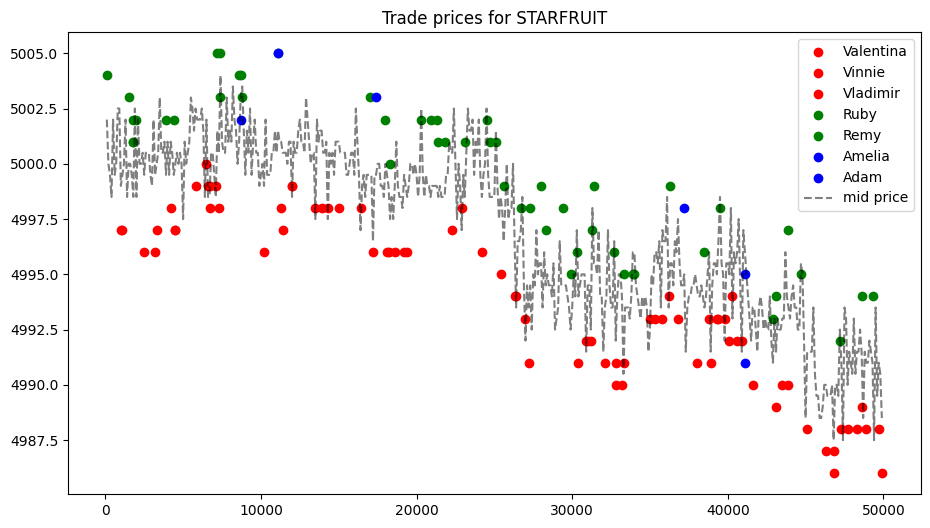

In [92]:
# Plot the trade prices for coconut for each bot against timestamp
prod = 'STARFRUIT'
range = (0, 50000)

fig, ax = plt.subplots(figsize=(11, 6))

for b, c in zip(bots, bot_colours):
    if len(trades[prod][b]) == 0:
        continue
        
    time_mask = ((trades[prod][b]['timestamp'] > range[0]) 
                 & (trades[prod][b]['timestamp'] < range[1]))
    
    ax.scatter(trades[prod][b]['timestamp'][time_mask],
               trades[prod][b]['price'][:range[1]][time_mask], 
               label=b, color=c)
    
time_mask = ((orders[prod]['timestamp'] > range[0]) 
             & (orders[prod]['timestamp'] < range[1]))
ax.plot(orders[prod]['timestamp'][time_mask], 
        orders[prod]['mid_price'][time_mask], 
        label='mid price', color='black', linestyle='--', alpha=0.5)
plt.title(f"Trade prices for {prod}")
ax.legend()
plt.show()